# V3.2

Vocab size 105

In [1]:
from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchaudio.functional import edit_distance
import torch
import torchaudio
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import math
import pickle

In [4]:
torch.manual_seed(0)

In [2]:
base_dir = ''
audio_dir = os.path.join(base_dir, 'wav')
labels_dir = os.path.join(base_dir, 'labels')
model_dir = os.path.join(base_dir, 'model')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [3]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# Helper class for processing notes
# Basically keeps track of useful structures and helps translate between string and one-hot tensors
class Vocab:
    def __init__(self):
        self.note2idx = {'{': 0, '}': 1, '<unk>': 2, '<pad>': 3}
        self.note2count = {'{': 0, '}': 0, '<unk>': 0, '<pad>': 0}
        self.idx2note = {0: '{', 1: '}', 2: '<unk>', 3: '<pad>'}
        self.n_notes = 4

    def add_notes(self, notes_str):
        for note in notes_str.split():
            self.add_note(note)

    def add_note(self, note):
        if note not in self.note2idx:
            self.note2idx[note] = self.n_notes
            self.note2count[note] = 1
            self.idx2note[self.n_notes] = note
            self.n_notes += 1
        else:
            self.note2count[note] += 1

    def notes_to_indices(self, notes: str):
        note_indices = []
        for note in notes.split(' '):
            if note in self.note2idx:
              note_indices.append(self.note2idx[note])
            else:
              note_indices.append(self.note2idx['<unk>'])
        return note_indices

    def indices_to_notes(self, indices):
        note_str = ''
        for i in indices:
            if i in self.idx2note:
                note_str += self.idx2note[i]
            else:
                note_str += '<unk>'
            note_str += ' '
        return note_str[:-1]

In [4]:
class BassDataset(Dataset):
    def __init__(self, audio_dir, labels_dir, vocab):
        self.labels_dir = labels_dir
        self.labels = list(filter(lambda x: x.endswith('.txt'), os.listdir(labels_dir)))
        self.audio_dir = audio_dir
        self.vocab = vocab

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        audio_file = os.path.join(self.audio_dir, f'{idx}.wav')
        labels_file = os.path.join(self.labels_dir, f'{idx}.txt')
        # Load audio file, resample to 16kHz
        waveform, _ = librosa.load(audio_file, sr=16000)
        waveform = torch.tensor(waveform)

        # Load labels
        f =  open(labels_file, 'r')
        notes_str = f.read()
        notes = torch.tensor(self.vocab.notes_to_indices(notes_str))
        f.close()

        return waveform, notes

def collate_fn(batch):
    # Pad audio files and labels to the same length
    waveforms, labels = zip(*batch)
    padded_waveforms = torch.nn.utils.rnn.pad_sequence(waveforms, batch_first=True)
    # Pad index of label is 3
    padded_labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=3)
    return padded_waveforms, padded_labels

def build_dataloader(audio_dir, labels_dir, batch_size=1):
  # Load vocab
  vocab = Vocab()
  for label in os.listdir(labels_dir):
    with open(os.path.join(labels_dir, label), 'r') as f:
      vocab.add_notes(f.read())

  data = BassDataset(audio_dir, labels_dir, vocab)

  train_data, test_data = torch.utils.data.random_split(data, [int(0.9 * len(data)), len(data) - int(0.9 * len(data))])
  train_loader = DataLoader(train_data, shuffle=True, collate_fn=collate_fn, batch_size=batch_size)
  test_loader = DataLoader(test_data, shuffle=True, collate_fn=collate_fn, batch_size=batch_size)
  return vocab, train_loader, test_loader

In [5]:
# https://github.com/openai/whisper/blob/main/whisper/model.py
# Used for audio positional embedding
def sinusoids(length, channels, max_timescale=10000):
    """Returns sinusoids for positional embedding"""
    assert channels % 2 == 0
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)

class PositionalEncoding(nn.Module):
    # Adds PE to the target label
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 100):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        """
        Arguments:
            token_embedding: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class AudioEncoder(nn.Module):
    def __init__(self, n_state):
        super().__init__()
        self.n_state = n_state
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_state, kernel_size=256, stride=4, padding=1).to(device)
        self.pool1 = nn.MaxPool1d(kernel_size=64, stride=64, padding=1)
        self.conv2 = nn.Conv1d(in_channels=n_state, out_channels=n_state, kernel_size=3, stride=1, padding=1).to(device)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.layer_norm = nn.LayerNorm(n_state).to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(F.relu(x))
        x = self.conv2(x)
        x = self.pool2(F.relu(x))
        x = self.layer_norm(x.permute(0, 2, 1))
        positional_embedding = sinusoids(x.shape[1], self.n_state).to(x.dtype).to(device)
        x = x + positional_embedding
        return x

class Transcriber(nn.Module):
    def __init__(self,
             n_state: int,
             vocab,
             dropout: float = 0.2):
        super().__init__()
        self.vocab = vocab
        self.audio_encoder = AudioEncoder(n_state)
        self.transformer = nn.Transformer(d_model=n_state,
                                          num_encoder_layers=6,
                                          num_decoder_layers=6,
                                          dropout=dropout,
                                          batch_first=True)
        # converts one-hot labels of (T, vocab_size) to (T, n_filters)
        self.target_embedding = nn.Embedding(vocab.n_notes, n_state)
        # adds positional encoding to the embedded target
        self.positional_encoding = PositionalEncoding(n_state, dropout)
        self.generator = nn.Linear(n_state, vocab.n_notes)

    def forward(self, src, target):
        src = self.audio_encoder(src)    # (1, S, n_filters)
        tgt = self.target_embedding(target.to(device))  # (1, T - 1, n_filters)
        tgt = self.positional_encoding(tgt).to(device)  # (1, T - 1, n_filters)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.shape[1]).to(device)
        outs = self.transformer(src, tgt, tgt_mask=tgt_mask)
        outs = self.generator(outs)    # (1, seq, vocab_size)
        return outs

In [6]:
vocab, train_loader, test_loader = build_dataloader(audio_dir, labels_dir, batch_size=1)

In [10]:
vocab.n_notes

109

## Training

In [21]:
transcriber_v3_2 = Transcriber(n_state=256, vocab=vocab).to(device)

In [22]:
def train(model, epoch, log_interval=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.CrossEntropyLoss()
    model.train()
    losses = []
    for batch_id, (audio, label) in enumerate(train_loader):


        audio = audio.unsqueeze(1).to(device)
        label = label.to(device)
        optimizer.zero_grad()

        tgt_in = label[:, :-1]

        out = model(audio, tgt_in)

        tgt_out = label[:, 1:]

        loss = criterion(out.squeeze(0), tgt_out.squeeze(0))
        loss.backward()

        optimizer.step()

        losses.append(loss.item())
        if batch_id % log_interval == 0:
            print('-' * 50)
            print(f'Epoch {epoch} Batch {batch_id} Loss: {loss.item()}')
    return losses

def inference(model, audio: torch.Tensor) -> str:
    with torch.no_grad():
        model.eval()
        max_len = 22
        src = model.audio_encoder(audio.unsqueeze(0).to(device))  # (1, S, n_filters)
        memory = model.transformer.encoder(src)
        tgt = torch.zeros((1, max_len), dtype=torch.int32).to(device)
        tgt[0, 1:] = 2  # set first to SOS and the rest to <unk>
        tgt_mask = model.transformer.generate_square_subsequent_mask(tgt.shape[1]).to(device)
        for i in range(max_len - 1):
            tgt_in = model.target_embedding(tgt)  # (1, max_len, n_filters)
            tgt_in = model.positional_encoding(tgt_in)  # (1, max_len, n_filters)
            out = model.transformer.decoder(tgt_in, memory, tgt_mask=tgt_mask)  # (1, max_len, n_filters)
            out = model.generator(out)  # (1, max_len, vocab)
            out = F.softmax(out.squeeze(0)[:i + 1], dim=1).argmax(dim=1)[-1]  # int
            tgt[0, i + 1] = out
            if out == 1:
                # Found end token, stop
                break

        print(tgt[0])
        predicted = model.vocab.indices_to_notes(tgt[0].tolist()).split('<unk>')[0].strip()
        return predicted

In [23]:
train_losses = []
for epoch in range(20):
  train_losses += train(transcriber_v3_2, epoch + 1, log_interval=1000)

--------------------------------------------------
Epoch 1 Batch 0 Loss: 4.841602325439453
--------------------------------------------------
Epoch 1 Batch 1000 Loss: 4.506228446960449
--------------------------------------------------
Epoch 1 Batch 2000 Loss: 4.50283145904541
--------------------------------------------------
Epoch 1 Batch 3000 Loss: 4.566697120666504
--------------------------------------------------
Epoch 1 Batch 4000 Loss: 4.423245429992676
--------------------------------------------------
Epoch 1 Batch 5000 Loss: 4.247486591339111
--------------------------------------------------
Epoch 1 Batch 6000 Loss: 4.316568374633789
--------------------------------------------------
Epoch 1 Batch 7000 Loss: 4.614710330963135
--------------------------------------------------
Epoch 1 Batch 8000 Loss: 4.4325737953186035
--------------------------------------------------
Epoch 2 Batch 0 Loss: 4.4041924476623535
--------------------------------------------------
Epoch 2 Batch 

In [39]:
# Save model
model_sd_path = 'drive/MyDrive/audio/autobass-3.2.pth'
model_path = 'drive/MyDrive/audio/autobass-3.2.pt'
vocab_path = 'drive/MyDrive/audio/vocab-3.2.pkl'
torch.save(transcriber_v3_2.state_dict(), model_sd_path)
torch.save(transcriber_v3_2, model_path)
pickle.dump(transcriber_v3_2.vocab, open(vocab_path, 'wb'))

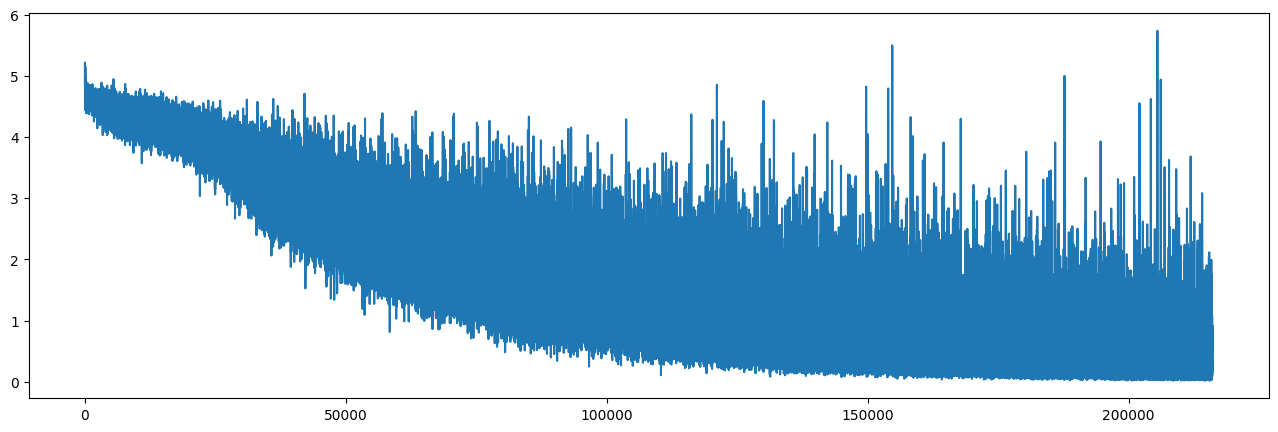

In [38]:
plt.figure(figsize=(16, 5))
plt.plot(train_losses)

# Evaluation

In [ ]:
loaded_model = torch.load(model_path, map_location=device)

In [34]:
def test(model, log_interval=100):
  with torch.no_grad():
      model.eval()
      max_len = 21
      ceds = []  # character edit distances
      weds = []  # word edit distances
      cers = []  # character error rates
      wers = []  # word error rates

      for batch_id, (audio, label) in enumerate(test_loader):
          src = model.audio_encoder(audio.unsqueeze(0).to(device))   # (1, S, n_filters)
          memory = model.transformer.encoder(src)

          tgt = torch.zeros((1, max_len), dtype=torch.int32).to(device)
          tgt[0, 1:] = 2  # set first to SOS and the rest to <unk>
          tgt_mask = model.transformer.generate_square_subsequent_mask(tgt.shape[1]).to(device)
          for i in range(max_len-1):
            tgt_in = model.target_embedding(tgt)  # (1, max_len, n_filters)
            tgt_in = model.positional_encoding(tgt_in)  # (1, max_len, n_filters)
            out = model.transformer.decoder(tgt_in, memory, tgt_mask=tgt_mask)  # (1, max_len, n_filters)
            out = model.generator(out)  # (1, max_len, vocab)
            out = F.softmax(out.squeeze(0)[:i+1], dim=1).argmax(dim=1)[-1]  # int
            tgt[0, i+1] = out
            if out == 1:
              # Found end token, stop
              break

          label = model.vocab.indices_to_notes(label[0].tolist())
          label_words = label.split(' ')
          predicted = model.vocab.indices_to_notes(tgt[0].tolist()).split('<unk>')[0].strip()
          predicted_words = predicted.split(' ')
          ced = edit_distance(label, predicted)
          wed = edit_distance(label_words, predicted_words)
          cer = ced / len(label)
          wer = wed / len(label_words)

          ceds.append(ced)
          weds.append(wed)
          cers.append(cer)
          wers.append(wer)

          if batch_id % log_interval == 0:
            print('-' * 20)
            print(f'Batch {batch_id}')
            print(f'Label:\t\t{label}')
            print(f'Predicted:\t{predicted}')
            print(f'Char distance:\t{ced}')
            print(f'Word distance:\t{wed}')
            print(f'Char error:\t{cer}')
            print(f'Word error:\t{wer}')

      print('-' * 20)
      print(f'Total test samples: {len(ceds)}')
      print(f'Avg char distance:\t{"{:.2f}".format(sum(ceds) / len(ceds))} characters')
      print(f'Avg word distance:\t{"{:.2f}".format(sum(weds) / len(weds))} words')
      print(f'Avg char error:\t{"{:.2f}".format(100 * sum(cers) / len(cers))}%')
      print(f'Avg word error:\t{"{:.2f}".format(100 * sum(wers) / len(wers))}%')
      return ceds, weds, cers, wers

In [37]:
_ = test(loaded_model, log_interval=100)

--------------------
Batch 0
Label:		{ b,8 f1 gis4 ais8 fis,4 d4 d16 e,2 cis4 g,2 gis2 g8 a,16 r4 cis16 a,4 ais16 a,4 f2 }
Predicted:	{ b,8 f1 gis4 ais8 fis,4 d4 d16 e,2 cis4 g,2 gis2 g16 a,16 r4 cis16 a,4 ais16 a,4 ais16
Char distance:	7
Word distance:	3
Char error:	0.08235294117647059
Word error:	0.14285714285714285
--------------------
Batch 100
Label:		{ d1 c16 f2 fis16 gis4 dis8 cis1 e,16 e,2 b1 gis,2 dis16 g1 a,8 dis8 g16 e16 }
Predicted:	{ d1 c16 f2 fis16 gis4 dis8 cis1 e,16 e,2 b1 gis,2 dis16 g1 a,8 g16 dis8 g16 dis8 }
Char distance:	8
Word distance:	2
Char error:	0.10256410256410256
Word error:	0.10526315789473684
--------------------
Batch 200
Label:		{ f2 c1 d8 b1 gis,2 f,4 e4 ais,2 a,8 fis8 g,16 b,16 e1 b,4 a,4 a16 }
Predicted:	{ f2 c1 d8 b1 gis,2 f,4 e4 ais,2 a,8 fis8 g,16 b,16 e1 b,4 a,4 a16 }
Char distance:	0
Word distance:	0
Char error:	0.0
Word error:	0.0
--------------------
Batch 300
Label:		{ ais4 ais,16 d2 r16 g1 cis4 gis,8 e,4 f,2 fis1 f,16 cis1 b2 }
Predicted:	{ 